# Australian Rainfall Predictor

**Introduction**
This project aims to predict whether it will rain tomorrow in Australia based on 10 years of daily weather observations sourced from **Keggle**.

----
Covers Data Loading, Pre-Processing, Exploratory Data Analysis, Training and Testing of Data, Training Model, Evaluation and Input Tester.

----

**The model correctly predicts whether it will rain tomorrow around 83.27% of the time based on the features**

----

Created by **Dafydd-Rhys Maund**

## Data Loading and Pre-Processing

In [94]:
# For data manipulation, analysis, computations and visualisations.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data and model management
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [70]:
# Mount files from Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
weather_dataset = '/content/drive/My Drive/Datasets/weatherAUS.csv'
data_frame = pd.read_csv(weather_dataset)
data_frame.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [71]:
# Shape of Data Frame

data_frame.shape

(145460, 23)

In [72]:
# Data Frame Information

data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [73]:
# Identify missing values and handle them
columns_with_missing = data_frame.columns[data_frame.isnull().any()]

for column in columns_with_missing:
    # Numerical columns: impute with mean
    if data_frame[column].dtype == 'float64':
        imputer = SimpleImputer(strategy='mean')
        data_frame[column] = imputer.fit_transform(data_frame[[column]])

    # Categorical columns: impute with mode
    else:
        imputer = SimpleImputer(strategy='most_frequent')
        data_frame[column] = imputer.fit_transform(data_frame[column].values.reshape(-1, 1))[:,0]
        # The reshape creates a 2D array expected by SimpleImputer, and uses first column.

# Verify that all missing values have been handled
print(data_frame.isnull().sum())

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64


In [74]:
#data_frame.duplicated().sum()
data_frame['Date'].duplicated().sum()

142024

## Exploratory Data Analysis

In [75]:
data_frame['RainTomorrow'].value_counts()

,count
RainTomorrow,
No,113583
Yes,31877


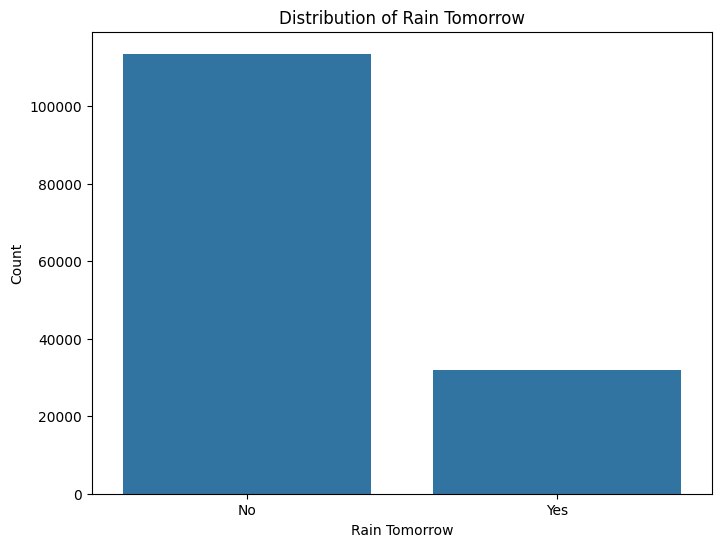

In [76]:
# Visualise the distribution

plt.figure(figsize=(8, 6))
sns.countplot(data=data_frame, x='RainTomorrow')
plt.title('Distribution of Rain Tomorrow')
plt.xlabel('Rain Tomorrow')
plt.ylabel('Count')
plt.show()

In [77]:
# Summary Statistics of Selected Numerical Features
numerical_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm']
data_frame[numerical_features].describe()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,Humidity9am,Humidity3pm
count,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000,145460.000000
mean,12.194034,23.221348,2.360918,40.035230,68.880831,51.539116
std,6.365750,7.088124,8.382488,13.118253,18.854765,20.471189
min,-8.500000,-4.800000,0.000000,6.000000,0.000000,0.000000
25%,7.700000,18.000000,0.000000,31.000000,57.000000,37.000000
50%,12.100000,22.700000,0.000000,39.000000,69.000000,51.539116
75%,16.800000,28.200000,1.000000,46.000000,83.000000,65.000000
max,33.900000,48.100000,371.000000,135.000000,100.000000,100.000000


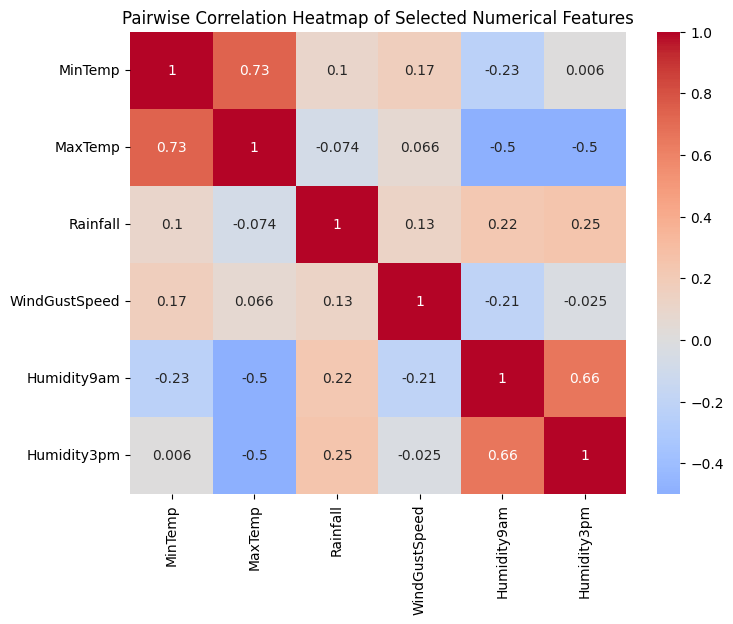

In [78]:
# Pairwise Correlation Heatmap of Selected Numerical Features

plt.figure(figsize=(8, 6))
sns.heatmap(data_frame[numerical_features].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Pairwise Correlation Heatmap of Selected Numerical Features')
plt.show()

<Figure size 1000x600 with 0 Axes>

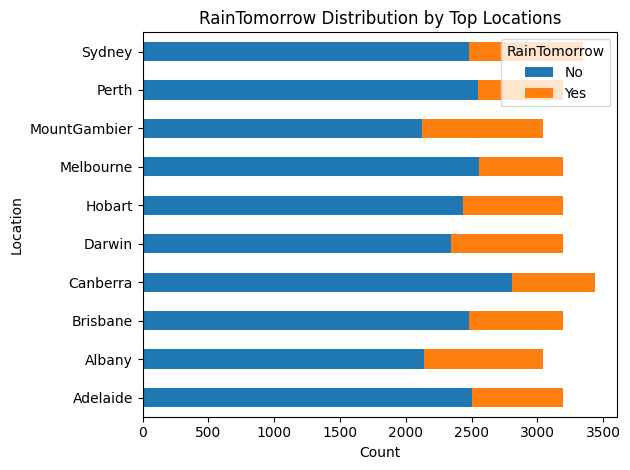

In [79]:
# Select top 10 locations with the highest counts
top_locations = data_frame['Location'].value_counts().head(10).index

# Filter the DataFrame for top locations
top_location_df = data_frame[data_frame['Location'].isin(top_locations)]

# Visualize the distribution of RainTomorrow across top locations
plt.figure(figsize=(10, 6))
location_rain_distribution = top_location_df.groupby(['Location', 'RainTomorrow']).size().unstack()
location_rain_distribution.plot(kind='barh', stacked=True)
plt.title('RainTomorrow Distribution by Top Locations')
plt.xlabel('Count')
plt.ylabel('Location')
plt.legend(title='RainTomorrow')
plt.tight_layout()
plt.show()

## Training and Testing Data

In [80]:
features = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm']

In [81]:
# Prepare the data

X = data_frame[features]
y = data_frame['RainTomorrow']

In [82]:
# Convert 'RainTomorrow' to binary, more suitable for binary classification models

data_frame['RainTomorrow'] = data_frame['RainTomorrow'].replace({'Yes': 1, 'No': 0})
data_frame['RainTomorrow'].value_counts()

<ipython-input-82-70d6a675a968>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_frame['RainTomorrow'] = data_frame['RainTomorrow'].replace({'Yes': 1, 'No': 0})


,count
RainTomorrow,
0,113583
1,31877


In [83]:
# Split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [84]:
# Create a StandardScaler instance and transform data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Training the Model and Evaluation

In [85]:
# Create and train the model and make predictions

model = LogisticRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [95]:
# Calculate accuracy

accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy:", accuracy)

Model accuracy: 0.8327031486319263


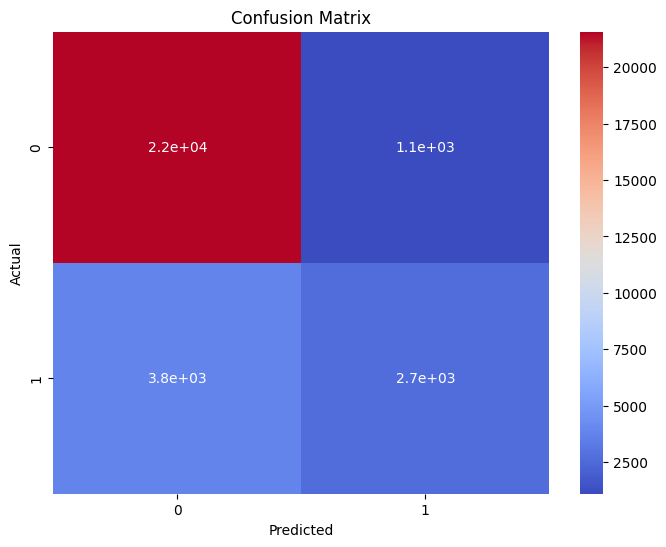

In [87]:
# Confusion Matrix - this looks for false/true positives and negatives - ranging from -1 to 1.
# [[True Negative (TN)  False Positive (FP)]
# [False Negative (FN) True Positive (TP)]]

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True,cmap="coolwarm")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [88]:
# Model Evaluation with Precision, Recall, and F1-Score

report = classification_report(y_test, y_pred, target_names=['No Rain', 'Rain'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     No Rain       0.85      0.95      0.90     22672
        Rain       0.71      0.41      0.52      6420

    accuracy                           0.83     29092
   macro avg       0.78      0.68      0.71     29092
weighted avg       0.82      0.83      0.82     29092



Precision is the percentage of predicted positives that are actually positive.

Recall is the percentage of actual positives that are predicted positive.

F1-score is a weighted harmonic mean of precision and recall.

## Given the features today. will it rain tomorow:

In [89]:
# Define the new input features as a dictionary

new_input = {'MinTemp': 0, 'MaxTemp': 0, 'Rainfall': 999999999,
             'WindGustSpeed': 0, 'Humidity9am': 999999999, 'Humidity3pm': 999999999}

In [91]:
new_input

{'MinTemp': 0,
 'MaxTemp': 0,
 'Rainfall': 999999999,
 'WindGustSpeed': 0,
 'Humidity9am': 999999999,
 'Humidity3pm': 999999999}

In [92]:
# Create a NumPy array from the dictionary values

new_input_np = np.array(list(new_input.values())).reshape(1, -1)
new_input_np

array([[        0,         0, 999999999,         0, 999999999, 999999999]])

In [93]:
# Make predictions on the new input

prediction = model.predict(new_input_np)
if prediction == 1:
    print('Yes, it will rain tomorrow.')
else:
    print('No, it will not rain tomorrow.')

No, it will not rain tomorrow.
